# Monte-Carlo photon spectrum generation of inverse Compton scattering from a (weak) laser undulator #
Oct 2021
R. Loewen

## About the notebook ##

This is an interactive notebook to generate spectra for different ICS configurations. These configurations primarily address electron storage ring ICS sources.  The bunch frequency of a storage ring is well matched to that of an optical cavity, which builds up laser pulses at repetition rate of tens of MHz.  Since the interaction frequency is high, optical pulse energies are relatively low.

Given this context, we allow for a few assumptions. One is that the laser intensity is low enough that it acts as a weak undulator (K<<1). A second is that the interaction point (IP) is at an electron beam focus localized in $\hat{z}$.  By localized, we mean the focused spot is small compared to the distance from the IP to the output window. (Another common assumption is that there is no dispersion in the electron beam at the IP.)  The laser pulse is also considered to contain many undulator periods. Given the above assumptions, we treat the ICS interaction as a classic ***weak undulator***.

This notebook is **not** a *Luminosity* calculation (ph/s). Instead, we take a total number of scattered photons and calculate what happens to them.  Yet this calculation *does* give the **relative intensity** both spatially and spectrally. If we know the *Luminosity*, we will then know the spectral ph/s density distribution in angle space.

#convert this cell to code when running on Colab
from google.colab import drive
drive.mount('/content/drive/')

## Organize functions by using @dataclass  ##
The following figure conceptually illustrates the different classes in organizing the code. Below the figure is a list of dependencies.  We cover more details of each of the classes as we go through them.  Each `dataclass` section contains all its attributes and methods.  We follow that with another section illustrating some examples. Feel free to edit or play with them.
![class_diagram.png](../pics/class_diagram2.png)
- **ebeam**( ) is independent 
  - **laser**(ebeam) also generates luminous spot size
     - **histogram** (ebeam, laser) to control how scattering data is collected
        - **aperture** (histogram) to calculate geometrical effects, transmission
           - **photons** (ebeam, laser, aperture) for ICS calculations
- ‘main’ function of code is to call/convert **photons** -> **histogram \[data\]**
- **display**(data, histogram, aperture)
- **configuration**(ebeam, laser, histogram, aperture) to save/recall specific configurations

## Let's get started with import ##
First import packages that are used in project.

In [59]:
from dataclasses import dataclass
import math as m
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import time
%load_ext cython
# for saving/recalling configs
import pickle 
import tkinter as tk
from tkinter import filedialog

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


## class ebeam: ##
We define an **electron beam** at the IP to derive ebeam distributions. We will need: $E,\sigma_E$, $\sigma_x,\sigma_{x'}$, $\sigma_{y},\sigma_{y'}$. The longitudinal attributes are mean energy (`.meanMeV`) and relative energy spread (`.sigmaErel`). Convenient transverse attributes are emittances, by default *normalized* (`.emittanceX`, `.emittanceY`) and beta functions at the IP (`.betastarX`,`.betastarY`).  (Coupling and correlations are not addressed.) The class also contains methods to generate random Gaussian distributions for batches of electrons. Those distributions are inputs for later scattering calculations. 


In [60]:
@dataclass
class ebeam:
    meanMeV:    float  # average energy (MeV)
    sigmaErel:  float  # relative energy spread dE/E
    emittanceX: float  # usually normalized emittance (m)
    emittanceY: float  #
    betastarX:  float  # beta* at IP (m)
    betastarY:  float  #
    useNormEmit: bool = True  # just in case, there are times we specify the geometric emittance instead
    def gamma(self):
        return self.meanMeV/0.510998950
    def emitX(self):
        return self.emittanceX/self.gamma() if self.useNormEmit else self.emittanceX
    def emitY(self):
        return self.emittanceY/self.gamma() if self.useNormEmit else self.emittanceY
    def sigmaX(self):
        return m.sqrt(self.emitX()*self.betastarX)
    def sigmaY(self):
        return m.sqrt(self.emitY()*self.betastarY)
    def sigmaXp(self):
        return m.sqrt(self.emitX()/self.betastarX)
    def sigmaYp(self):
        return m.sqrt(self.emitY()/self.betastarY)
    """ TBD: add functions to read equilibrium ICS energy distribution
          from storage ring turn-by-turn simulation (another code)"""
    # use beam parameters above to calculate sample electron(s) for ICS photon(s)
    def eMeV(self,n=1):
        return np.random.default_rng().normal(self.meanMeV, self.meanMeV*self.sigmaErel, n)
    def esigmaX(self,n=1):
        return np.random.default_rng().normal(0, self.sigmaX(), n)
    def esigmaY(self,n=1):
        return np.random.default_rng().normal(0, self.sigmaY(), n)
    def esigmaXp(self, Xp_offset, n=1):
        return np.random.default_rng().normal(Xp_offset, self.sigmaXp(), n)  
    def esigmaYp(self, Yp_offset, n=1):
        return np.random.default_rng().normal(Yp_offset, self.sigmaYp(), n)

In [61]:
# example beam input
#examplebeam = ebeam(58.0,3.2e-3,7.5e-6,7.5e-6, 0.200, 0.200)
examplebeam = ebeam(237,7.81e-4,5.02e-6,5.02e-6, 10.0, 10.0)
print(examplebeam)
print(examplebeam.emitX())
print('here are 5 sample values for electron energy', examplebeam.eMeV(5))

ebeam(meanMeV=237, sigmaErel=0.000781, emittanceX=5.02e-06, emittanceY=5.02e-06, betastarX=10.0, betastarY=10.0, useNormEmit=True)
1.0823690839662446e-08
here are 5 sample values for electron energy [236.91490224 237.0294363  237.01259602 236.7023311  236.68867142]


## class laser: ##
Define **optical parameters** of interaction laser, including calculation of luminous (x-ray) spot size. We assume here that the bandwidth of the optical pulse is much smaller than that of the electron beam energy spread. So we ignore it. We characterize the photon energy with only the laser wavelength (`.nm`).  (We neglect the finite oscillation bandwidth.) In other words, an optical pulse acts like an infinite period undulator.  Thus geometrical properties of the scattered optical photon do not contribute much to the spectral or spatial distribution of ICS.  Only through the luminous spot size, if large enough compared to the IP to exit-aperture distance, will it affect the ICS distribution.  The luminous spot size acts as an added angular divergence (smearing of the point source) due to geometry.  We can add this divergence independent of the ebeam divergence.  To calculate the luminous spot size, we need to specify the laser depth of focus (`.zRayleighX`,`.zRayleighY`).  We include $\hat{z}$ position offsets (`.zOffsetX`,`.zOffsetY`) if the focus is not coincident with the electron beam or is astigmatic.  Not entering offsets assumes they are 0.

In [62]:
@dataclass
class laser:
    nm: float                 # laser wavelength (nm)
    ps: float                 # polarization state, h=1, v=-1 or 0 for unpolarized
    zRayleighX: float         # Rayleigh Range (m) in x
    zRayleighY: float         # Rayleigh Range (m) in y
    zOffsetX: float = 0       # position offset in z (m) in x
    zOffsetY: float = 0       # position offset in z (m) in x
    def eV(self):
        return 1239.8/self.nm
    def w0X(self):
        return m.sqrt(self.nm*1e-9*self.zRayleighX/m.pi)
    def w0Y(self):
        return m.sqrt(self.nm*1e-9*self.zRayleighY/m.pi)
    def wOffX(self):
        return m.sqrt(1 + (self.zOffsetX/self.zRayleighX)**2)
    def wOffY(self):
        return m.sqrt(1 + (self.zOffsetY/self.zRayleighY)**2)
    def sigmaX(self):
        return self.w0X()*self.wOffX()/2
    def sigmaY(self):
        return self.w0Y()*self.wOffY()/2
    # we can also characterize the luminous spot by folding in the electron beam
    def luminous_sigmaX(self,ebeam):
        return m.sqrt((ebeam.sigmaX()**2)*(self.sigmaX()**2)/(ebeam.sigmaX()**2 + self.sigmaX()**2))
    def luminous_sigmaY(self,ebeam):
        return m.sqrt((ebeam.sigmaY()**2*self.sigmaY()**2)/(ebeam.sigmaY()**2 + self.sigmaY()**2))
    # use beam parameters above to generate samples for spot size distributions to be applied to ICS photon(s)
    def lumsigmaX(self,ebeam, n, offset=0):
        return np.random.default_rng().normal(offset, self.luminous_sigmaX(ebeam), n)
    def lumsigmaY(self,ebeam, n, offset=0):
        return np.random.default_rng().normal(offset, self.luminous_sigmaY(ebeam), n)

In [63]:
# example laser input
exampleNdYAG = laser(1064,1,0.06,0.06)
print(exampleNdYAG)
print(f'laser has photon energy of {exampleNdYAG.eV():0.4f} eV')
print(f'laser spot size sigma_x = {exampleNdYAG.sigmaX():0.2e}')
print(f'ebeam spot size sigma_x = {examplebeam.sigmaX():0.2e}')
print(f'together makes a luminous spot size sigma x = {exampleNdYAG.luminous_sigmaX(examplebeam):0.2e}')
print('here are 4 sample values for beam spot in y',exampleNdYAG.lumsigmaY(examplebeam,4))

laser(nm=1064, ps=1, zRayleighX=0.06, zRayleighY=0.06, zOffsetX=0, zOffsetY=0)
laser has photon energy of 1.1652 eV
laser spot size sigma_x = 7.13e-05
ebeam spot size sigma_x = 3.29e-04
together makes a luminous spot size sigma x = 6.97e-05
here are 4 sample values for beam spot in y [ 0.00010706 -0.00017696 -0.00016611  0.00015433]


## class histogram: ##
Define **4D histogram** to assign bins to scattered angles and energies (x',y',E, p) where p is polarization (unpolarized=0, and linear sigma=1, pi=-1). This is the 'state space' we will use to calculate and then bin photons.  We treat x' and y' as having the same bin size and range for convenience.  We include methods to estimate the peak energy of scattered photons and apply a bandwidth of interest (from the peak energy down).  We can also take advantage of the photon distribution (described in the following section) to preset the range of sampled energies.  If we collect a range of energies, we can restrict the Monte Carlo random variable to this range.  This saves us from throwing away out-of-band photons.  We still track out-of-bound photons by including extra bins in the `histogram.createArray()`.  The data includes out-of-bound low and high indexes for x' y' and E (but not p) so we can account for all photons created.

### Monte-Carlo ICS part 1: mapping energy to a random sampling function ###
The histogram methods include calculations about which energies to track.  For this, we need the undulator photon distribution.  This is a good spot to illustrate the relevant formulas.  I am using Hofmann([^1]), in particular, his analysis of weak undulators.  The most useful formula to start with is the **power spectral density**, which is the power integrated over the solid angle.  We use Hofmann's formula for ***S<sub>u</sub>*** that combines both sigma and pi polarizations to include all photons. From ***S<sub>u</sub>*** we divide by photon energy to get the classic **photon distribution** "U" shaped ***P<sub>u</sub>***.  Next we integrate to get a normalized monotonic function ***CP<sub>u</sub>***.  This is the function we invert and sample (with random *P*) to get *x*, the normalized photon energy.

For individual electrons, that electron's energy determines the peak photon energy.  For the histogram, we calculate top energy from the estimated peak of the electron beam energy distribution. The `minP()` method looks at the lowest energy bin in the histogram and uses that to set the bandwidth, or lowest energy to sample with *P(x)*.  For example, if the lowest energy we want is 80% of the estimated peak, then the corresponding *minP* = 0.752 (green arrows). Using the inverse of ***CP<sub>u</sub>***, a random sampling above *minP* will fill in the appropriate upper part of curve ***P<sub>u</sub>***. (Later, in the `photons` dataclass,  we will talk about the inverse of ***CP<sub>u</sub>*** .)
![ICS_photon_distribution.png](../pics/ICS_photon_distribution.png)

[^1]: files/Hofmann_synchrotron_radiation.pdf

In [64]:
@dataclass
class histogram:
    theta: float     # largest +/- angle for x' and y' (rad)
    dtheta: float    # size of each angle bin (rad)
    minE: float      # lowest energy bin (eV)
    maxE: float      # highest energy bin (eV)
    dE: float        # size of each energy bin (eV)
    def estimateMaxE(self, ebeam, laser, precision = 0):   # add +6dE/E and round from there
        gamma2 = ((1+6*ebeam.sigmaErel)*ebeam.gamma())**2  # use this as upper bound for gamma^2
        return round(4*gamma2*laser.eV()/(1 + 4*gamma2*laser.eV()/(1e6*ebeam.meanMeV)), precision)
    def autoMaxE(self, ebeam, laser, precision = -3):
        newMaxE = self.estimateMaxE(ebeam, laser, precision)
        print(f'  ...new max {newMaxE:0.0f} replaces {self.maxE:0.0f} as histogram.maxE')
        self.maxE = newMaxE
        return
    def setBW(self, bandwidth = 1, precision = -3):    # call after checking or setting it with autoMaxE()
        if bandwidth > 1.0: bandwidth = 1.0, print('bandwidth must be <1')
        else:
            newMinE = round((1-bandwidth)*self.maxE, precision) 
            print(f'  ...new min {newMinE:0.0f} replaces {self.minE:0.0f} as histogram.minE')
            self.minE = newMinE
        return
    def E_bins(self):
        return int((self.maxE - self.minE)/self.dE) + 2  # +2 for out-of-bounds collection +/-
    def array_E_bins(self):
        return np.linspace(self.minE, self.maxE, self.E_bins() - 2)  # don't include out-of-bounds for search
    def theta_bins(self):
        return int(2*self.theta/self.dtheta) + 2 # +2 for out-of-bounds collection +/-
    def array_theta_bins(self):
        return np.linspace(-1*self.theta, self.theta, self.theta_bins() - 2) # don't include out-of-bounds
    def minP(self,ebeam,laser):   # P[0..1] but we don't need to track low energy photons -> P[minP..1] 
        fractionE = m.floor(100*self.minE/self.estimateMaxE(ebeam,laser,-3))/100  # round down to nearest %
        minP = 3/2*fractionE - 3/2*fractionE**2 + fractionE**3  # this is lower bound of what we need to sample
        return minP, 1-fractionE  # we use minP later, but we can also use the bandwidth to scale output flux correctly
    def createArray(self):        # for now, put in 3 bins for polarization (unpolarized and two for linear)
        return np.zeros((self.theta_bins(), self.theta_bins(), self.E_bins(), 3), dtype=np.int64)  # 64bit for cython 

In [65]:
# example histogram input
#examplehist = histogram(4e-3, 80e-6, 10e3, 40e3, 200)
examplehist = histogram(1e-3, 50e-6, 980e3, 1020e3, 400)
print(f'initial {examplehist}')
print('If we want, we can calculate and set the min and max energies')
print(examplehist.estimateMaxE(examplebeam,exampleNdYAG,-1))
examplehist.autoMaxE(examplebeam,exampleNdYAG,-3)   #to set the high energy cutoff (call first)
examplehist.setBW(0.03)                              #to set the low energy cutoff
print(f'modified to {examplehist}')
#print(examplehist.array_theta_bins())
# use histogram settings to define array
exampledata = examplehist.createArray()
print(f"{exampledata.shape} are the available bins to put a scattered photon in (x', y', E, p) space")
minP = examplehist.minP(examplebeam,exampleNdYAG)[0]
BW = examplehist.minP(examplebeam,exampleNdYAG)[1]
print(f'minimum P [0..1] is {minP} for a sampled BW of {BW*100:0.1f}%')

initial histogram(theta=0.001, dtheta=5e-05, minE=980000.0, maxE=1020000.0, dE=400)
If we want, we can calculate and set the min and max energies
1007710.0
  ...new max 1008000 replaces 1020000 as histogram.maxE
  ...new min 978000 replaces 980000 as histogram.minE
modified to histogram(theta=0.001, dtheta=5e-05, minE=978000.0, maxE=1008000.0, dE=400)
(42, 42, 77, 3) are the available bins to put a scattered photon in (x', y', E, p) space
minimum P [0..1] is 0.9563230000000001 for a sampled BW of 3.0%


## class aperture: ##
Create an **aperture** to define a mask geometry for angular acceptance.  The aperture can also define output window characteristics, like attenuation. This also makes a good detector plane where we can specify source to output distance.  This distance converts luminous source size to angles (see section after aperture examples below).  Since the output aperture may be part an optical mirror (as in the Lyncean CLS), we include features of the substrate as well as the 'thinned' output area. The 'thick' substrate may affect the geometrical acceptance, like a tilt angle of an otherwise circular aperture. For the thin part of the output window, we use data from a lookup table available from NIST* to calculate energy dependent transmission. Silicon is the default material.

*<https://physics.nist.gov/PhysRefData/FFast/html/form.html> and pick 2.00-433keV, for example, and save as text file.

In [85]:
@dataclass
class aperture:
    toIP: float           # distance from aperture to IP (m)
    dia: float            # diameter of circular hole (m)
    thick: float = 0      # thickness of aperture, such as substrate of a locally thinned optic (m)
    angle: float = 0      # tilt angle, as from an optic substrate in a cavity (deg)
    thin: float = 0       # thickness of apertured window itself (m)
    material: str = 'Si'  # silicon is nominal material - can add others as needed
    #below are some aperture methods that require a given histogram ('detector' plane) 
    def transmission(self, hist):
        if self.thin <= 0:
            return np.ones(hist.E_bins())
        elif self.material == 'Si':
            SiNIST = np.loadtxt("NIST_Si_mu_table_2-433keV.txt", delimiter="\t")
            mu = np.interp(hist.array_E_bins(), SiNIST[:,0]*1e3, SiNIST[:,1])
            transmission = np.exp(-mu*self.thin*100)
            return np.roll(np.append(transmission,[0,0]),1) # add 0's to out-of-bounds energies
        else:
            print(f'{self.material} not a recognized material, no attenuation loaded')
            return np.ones(hist.E_bins())
    def createMask(self, hist):    # create a 'hard' aperture by creating a 2D array of 0's and 1's (histogram sized)
        m_offset =  m.sin(m.radians(self.angle))*self.thick  # cylinder tilt offset in m
        offset = m.atan(m_offset/2/self.toIP)/hist.dtheta    # m offset converted to histogram bins ('angle' space)
        midpoint = hist.theta/hist.dtheta + 1                # default is calculate everything in bins (+1 for oob)
        well = m.atan(self.dia/2/self.toIP)/hist.dtheta      # nominal radius of well
        left = midpoint - offset                             # each tilted edge appears transversely shifted
        right = midpoint + offset
        endpoint = int(2*midpoint)
        mask_left = np.empty([endpoint,endpoint])            # populate a mask to fill in with 0's or 1's
        mask_right = np.copy(mask_left)                      # do each side independently
        for x in range(0, endpoint):
            for y in range(0, endpoint):
                mask_left[x,y] = 1 if (((x-left)**2+(y-midpoint)**2) <= well**2) else 0
                mask_right[x,y] = 1 if (((x-right)**2+(y-midpoint)**2) <= well**2) else 0
        mask = mask_left * mask_right                        # combine as 'AND'ed set for aperture
        return mask
    def properties(self, hist):   # a place to assemble some aperture calculations that may be interesting to know
        mymask = self.createMask(hist)
        # max subtended angles in each plane
        width_rad = hist.dtheta*np.sum(mymask[:,int(mymask.shape[0]/2)])  # count 1's across the middle
        height_rad = hist.dtheta*np.sum(mymask[int(mymask.shape[1]/2),:])
        # area covered by aperture
        rel_area = np.sum(mymask)/((mymask.shape[0]-2)*(mymask.shape[1]-2))  # how much of histogram covered by aperture
        histogram_area_mm = (m.sin(hist.theta)*self.toIP*2*1e3)**2
        area_mm = rel_area*histogram_area_mm
        return width_rad, height_rad, area_mm

In [86]:
# example aperture input
examplewindow = aperture(1.25,10e-3,12.7e-3,6.0,1e-3,'Si')
print(examplewindow)
print('transmission calculated for', examplewindow.transmission(examplehist).size, 'energies')
ans = examplewindow.createMask(examplehist)
print(ans.shape)
#print(examplewindow.transmission(examplehist))
print(f"sigma of x' distribution due to luminous spot = {exampleNdYAG.luminous_sigmaX(examplebeam)/examplewindow.toIP}")

aperture(toIP=1.25, dia=0.01, thick=0.0127, angle=6.0, thin=0.001, material='Si')
transmission calculated for 77 energies
(42, 42)
sigma of x' distribution due to luminous spot = 5.572773504818053e-05


### Note on luminous spot size ###

Since we are tracking *angle space* (x', y') of photons, we can pick any length past the aperture as the detector plane.  The most natural plane to take a look is right where we put an output window, or aperture. This is usually far from the source compared to the source size.  In this case, simple geometry determines the angular effect of the luminous spot size. We get **d** in the figure below from the attribute `aperture.toIP` distance.
![source_size_angles.png](../pics/source_size_angles.png)

## class photons: ##
This is where we calculate ICS and generate the states (as attributes) of a collection of **photons**.  The main method called is `scatter()` which assigns values to the four photon attributes. First it generates a set of Monte-Carlo 'x' (normalized photon energy) values `Px`. For a particular `Px` we know the energy of the photon `.eV`.  The next calculation determines the polarization `.ps` (if laser photons are linearly polarized).  The polarization state affects the angular distribution in x', y' space. Knowing the polarization and photon energy, we determine the angles x', y' or `.xp`, `.yp`.  

The trick here is to use `Numpy` as much as possible, so we vectorize everything with arrays. In other words, we calculate a batch of photons at a time, for instance 1M, and then add them to a data histogram.  We may add batches of photons to the histogram data by calling the same `scatter()` method.

The following description of ICS calculations consider a single electron at a time.  We can add the effects of the electron beam distribution as we go along, or at the end.  Similarly for the luminous spot effect.  If we add beam correlations from position  ($\sigma_x$) to angle space ($\sigma_{x'}$), we would have include it as we go.  For the case where the beam is not correlated, we can add in the effects at the very end.

### Monte-Carlo ICS part 2: scattering formulas ###
We start with generating the ***P<sub>u</sub>*** photon distribution as samples `Px` from a uniform random number distribution [0..1]. We can limit the range by setting a floor for P(x), called from `histogram.minP()`. The integrated formula that we need is the inverse of ***CP<sub>u</sub>*** shown earlier in the `histogram` section.  This is simple enough to be algebraically inverted.  (And each axis is already normalized to unity.)
From Maple, we get the inverse of ***CP<sub>u</sub>***, which is coded in `.generate_Px()`:
![inverted_MC_formula.png](..\pics\inverted_MC_formula.png)

The *undulator formula* gives us the backscattered photon energy. It includes the recoil term in the denominator, which is relevant for gamma-ray energies.  The maximum energy is straight ahead, $\theta=0$.  The normalized photon energy $E_{ph}/E_{max}$ is the `Px` we generated with our Monte-Carlo distribution.
![undulator_eq_insert.png](..\pics\undulator_eq_insert.png)

Once we specify the normalized energy of a scattered photon, the $\theta$ component is correlated exactly (with a factor of $\gamma$).  This angle is relative to where the electron is pointing ($\theta\equiv0$).  The coordinate system we use is:
![geometry.png](..\pics\geometry.png)

The last piece of information we need is the angle $\phi$ distribution. The angle $\phi$ depends on the plane of polarization, and the polarization mode ($\sigma$ or $\pi$).  If unpolarized, I set $\phi$ to be randomly distributed over $2\pi$. If we have a linearly polarized laser in $\hat{x}$, there will mostly be $\sigma$-mode polarization at low angles, or high energies. There is a mix of $\pi$-mode at larger angles, as seen in the following figure.  
![photon_distribution.png](..\pics\photon_distribution.png)

Taking advantage of Hofmann's analysis, the problem can be split up in to two parts. First, we determine what polarization the photon has. For this, we go back to the **power spectral density** formulas, but this time we use the one for ***S<sub>u$\sigma$</sub>*** as well as ***S<sub>u</sub>***.
![power_spectral_density.png](..\pics\corrected_spectral_power_density.png)

For a given `Px` (in Hofmann's notation $\frac{\omega}{\omega_{10}}$) we find the ratio of ***S<sub>u$\sigma$</sub>*** compared to the sum ***S<sub>u</sub>***.  A random number determines whether the photon is $\sigma$- or $\pi$-mode.  Once we know the polarization state, we use the **spectral angular power**, which contains the explicit $\phi$ dependence, to make a distribution that matches these functions
![spectral_angular_power.png](..\pics\spectral_angular_power_for_phi.png)

The dataclass contains two different methods that should allow us to find $\phi$.  One is the `explicitPhi()` calculation that first generates a function for a particular `Px`.  Integrating this function creates a map of $\phi$ to a random number.  (This method is not presently working. To make it work for inverting 2D inputs, it requires building another function to handle broadcasting correctly.) The second method is an `interpolatePhi()` routine which interpolates both `Px` and $\phi$ from a 2D lookup table.  We generate the table once, then use it to find $\phi$ given `Px` and a random number.  This second method is  working (although likely slower than it should be.)

In [87]:
%%cython
# this turns out no faster than vectorized python function
cimport numpy as np
import numpy as np     # need to import both
def cyInverseInterp(np.ndarray[np.float64_t, ndim=1] x, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] Y):
    dX = np.diff(X, axis=0)
    dY = np.diff(Y, axis=0)
    w = np.clip((x - X[:-1, :])/dX[:, :], 0, 1)
    return np.sum(w*dY[:,None], axis=0)

In [125]:
@dataclass
class photons:
    xp : [float]   # horizontal angles (rad)
    yp : [float]   # vertical angles (rad)
    eV : [float]   # energies (eV)
    ps : [float]   # polarization states (sigma=1, pi=-1, unpolarized=0)
    def scatter(self, n, ebeam, laser, table, minP = 0): # top function to modify photon attibutes for n given random P(x)'s
        Px = self.generate_Px(n, minP)   # inverted Monte Carlo probability distribution [Pmin..1]
        self.eV = self.energy(ebeam, laser, Px)           # energy of scattered photon
        self.ps = self.polarization(Px) if laser.ps != 0 else np.zeros(n)  # polarization state depends on P(x)
        self.xp, self.yp = self.angles(ebeam, laser, Px, table)  # call polarization first because we read .ps attribute
        return
#   Below are methods called from scatter(), starting with the undulator photon energy distribution P(x)
    def generate_Px(self, n, minP = 0):  # MC probability function for weak undulator, mapping energy of scattered photon
        y = minP + np.random.random(n)*(1 - minP)
        term = -2 + 4*y + np.sqrt(5 - 16*y + 16*y*y)
        return (term**(2./3) -1 + term**(1./3))/2/term**(1./3)
    def energy(self, ebeam, laser, Px):   # once we know P(x) we can easily scale from max energy
        n = np.size(Px)
        gamma2 = (ebeam.eMeV(n)/0.510998950)**2
        maxE = 4*gamma2*laser.eV()/(1 + 4*gamma2*laser.eV()/(1.0e6*ebeam.eMeV(n)))
#        maxE = 1.0e6*ebeam.eMeV(n)*(4*gamma2*laser.eV())/(1.0e6*ebeam.eMeV(n) + 4*gamma2*laser.eV())
        return Px*maxE
    def polarization(self, Px):          # first determine probability for s or p (assuming planar undulator)
        Hofmann_Su = (1 - 2*Px + 2*Px*Px)        # spectral photon density from Hofmann for sum of sigma + pi
        Hofmann_Su_s = (1/2 - Px + 3/2*Px*Px)    # spectral photon density from Hofmann for sigma only
        ratio_s_u = Hofmann_Su_s/Hofmann_Su   # use ratio as threshold for determining which state
        p = np.where(np.less(np.random.random(np.size(ratio_s_u)), ratio_s_u), 1, -1)
        return p
    def angles(self, ebeam, laser, Px, table):
        n = np.size(Px)
        gamma2 = (ebeam.eMeV(n)/0.510998950)**2
        theta = np.sqrt((1-Px)/Px/gamma2)                # full angle theta known (although not phi yet)
        phi = self.interpolatePhi(self.ps, Px, table)[1] # returns functional polarization dependent phi distribution
#       phi = self.explicitPhi(self.ps, P)[1]            # this is not working, and may be slower than lookup table anyway
        if laser.ps == 0: phi = phi + m.pi/2             # above is laser vertical polarization; rotate if horizontal
        thetaX = theta*np.cos(phi) #+ ebeam.esigmaXp(0, n)  # manage uncorrelated stuff in a separate method!
        thetaY = theta*np.sin(phi) #+ ebeam.esigmaYp(0, n)  # ...these act like a convolution to ICS distribution
        return thetaX, thetaY
    def explicitPhi(self, ps, Px): # generate CP function for specific P, then invert by interpolation? (does not work!)
        n = np.size(Px)
        x = np.random.random(n)
        q = 50                                  # value large enough to interpolate when inverted, 100 is good
        gts = (1-Px)/Px                           # (1-P)/P = (gamma*theta)**2 or'gts' for sigma distribution
        phi = np.linspace(0,2*m.pi,q)
        def sigmaPhi(x, phiD, gtsD):
            phi = np.tile(phiD,[np.size(x),1])  # this turns the problem to 2D but interp still has a problem
            gts = np.transpose(np.tile(gtsD,[np.size(phiD),1])) # as above
            CP = (4*phi-4*gts*np.sin(2*phi)+gts*gts*np.cos(2*phi)*np.sin(2*phi)+2*gts*gts*phi)/(4*m.pi*(2+gts*gts))
            return np.interp(x, CP, phi)
        def piPhi(x, phi):
            CP = (-np.cos(2*phi)*np.sin(2*phi)+2*phi)/(4*m.pi)  # normalized pi-mode integral from phi 0..2Pi
            return np.interp(x, CP, phi)  # invert axes to sample CP function to return an actual value for phi
        value = np.where(ps != 0, np.where(ps==1, sigmaPhi(x, phi, Px), piPhi(x, phi)), x*2*m.pi)
        return x, value       # return both to check function; otherwise just need 'value' for actual phi
    def interpolatePhi(self, ps, Px, table):  # generate lookup table first, then interpolate for specific P (works!)
        x = np.random.random(np.size(Px))  # for sampling monte-carlo cumulative phi distribution (and invert to get phi)
        def multiInterp(x, X, Y):   # try a vectorized explicit interpolation for inverting
            dX = np.diff(X, axis=0)
            dY = np.diff(Y, axis=0)
            w = np.clip((x - X[:-1, :])/dX[:, :], 0, 1)
            return np.sum(w*dY[:,None], axis=0)    
        def sigmaPhi(x, Px, table):
##            a = time.perf_counter()
            pFracIndex = np.interp(Px, table[0], np.arange(np.size(table[0])))
##            b = time.perf_counter()
#            f_phi = [np.interp(pFracIndex, np.arange(np.size(table[0])), table[2][:,j]) for j in range(np.size(table[1]))]
            my_interp = interp1d(np.arange(np.size(table[0])),table[2].T)  #'from scipy.interpolate import interp1d'
            f_phi = my_interp(pFracIndex)   # does the above commented loop but in scipy as a function - faster
##            c = time.perf_counter()
#            ans = cyInverseInterp(x,f_phi,table[1])     # tried cython but no faster than vectorized python multiInterp()
            ans = multiInterp(x,f_phi,table[1])          # use a vectorized interpolation, a bit faster than line below
##           d = time.perf_counter()
#            ans = [np.interp(x[j],f_phi[:,j],table[1]) for j in range(np.size(Px))]  # this works OK, probably a better way
##            print(f'{b - a:0.5f} ; {c - b:0.5f} ; {d - c:0.5f}')
            return ans 
        def piPhi(x, table):  # invert axes to sample CP function to return value for phi
            return np.interp(x, table[3], table[1])
        value = np.where(ps != 0, np.where(ps==1, sigmaPhi(x, Px, table), piPhi(x, table)), x*2*m.pi)
        return x, value       # return both to check function; otherwise just need 'value' for actual phi
    def generatePphiTable(self, p, n, Pfloor = 0.01):   # do this once and use interpolatePhi() to invert
        samplesP = np.linspace(Pfloor, 1.0, p)
        samplesPhi = np.linspace(0, 2*m.pi ,n)
        CPps = np.empty([p,n]) # s polarization phi distribution is dependent on photon energy
        CPp = np.empty([n])    # p polarization phi distribution is independent of photon energy
        for x, P in np.ndenumerate(samplesP):
            A = (1-P)/P
            for y, phi in np.ndenumerate(samplesPhi):
                CPps[x,y] = (4*phi-4*A*m.sin(2*phi)+A*A*m.cos(2*phi)*m.sin(2*phi)+2*A*A*phi)/4/m.pi/(2+A*A)
        for y, phi in np.ndenumerate(samplesPhi):
                CPp[y] = (-m.cos(2*phi)*m.sin(2*phi)+2*phi)/4/m.pi
        return samplesP, samplesPhi, CPps, CPp
#   Below are methods that modify our 'point source' ICS photon distribution
#   We could make a copy of the base ICS distribution and change (non-energy aspects) of ebeam/laser/aperture
    def add_ebeam_divergence(self, ebeam, xp_offset, yp_offset):  # set offsets to '0' to center beam to aperture
        n = np.size(self.xp)
        self.xp = self.xp + ebeam.esigmaXp(xp_offset, n)
        self.yp = self.yp + ebeam.esigmaYp(yp_offset, n)
        return
    def add_luminous_spot_effects(self, ebeam, laser, aperture, x_offset=0, y_offset=0):
        n = np.size(self.xp)
        self.xp = self.xp + laser.lumsigmaX(ebeam, n, x_offset)/aperture.toIP # convert source position to angles at aperture
        self.yp = self.yp + laser.lumsigmaY(ebeam, n, y_offset)/aperture.toIP
        return

photons(xp=array([ 0.00333396, -0.00047101,  0.00050182,  0.00033715,  0.00047059,
       -0.0129041 ,  0.00017528,  0.00178618,  0.00015403, -0.00105894]), yp=array([-4.77606530e-03, -2.53512960e-03, -2.61257820e-05,  2.32054234e-03,
        1.04345063e-03, -7.57320683e-03, -1.39977742e-03, -2.10666002e-03,
       -3.16737059e-03, -8.82111131e-04]), eV=array([120592.48310903, 411569.09704888, 947181.20775108, 456444.10636036,
       778479.39466403,  20391.83342951, 700014.50102386, 377721.13031267,
       316320.71560232, 710188.44693897]), ps=array([-1, -1,  1,  1,  1, -1,  1, -1,  1,  1]))


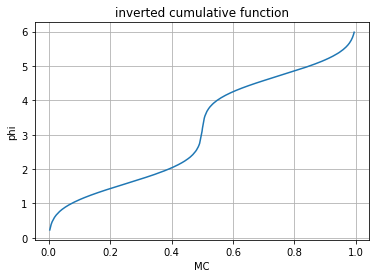

In [126]:
#example photons input
examplePhotons = photons([],[],[],[])  # empty to start, but we need an object to collect results
exampleLookUp = examplePhotons.generatePphiTable(50, 100)  # set 2D size for interpolation table
examplePhotons.scatter(10,examplebeam,exampleNdYAG,exampleLookUp)  # need input beams, like from previous examples
print(examplePhotons)  # here is a set of n photon states,organized in 1D arrays, each of length n.
# spot check interpolated inverse function for phi (e.g. ps=1, P=0.6)
v = np.zeros([500,2])
for x in range(0, 500):  # pick some number to randomly sample (with same Px) and then sort them to plot
    value, phi = examplePhotons.interpolatePhi(1,[0.6],exampleLookUp)
    v[x] = value[0], phi[0]
v = np.sort(v,0)
fig, ax = plt.subplots()
ax.plot(v[:,0], v[:,1])
ax.set(xlabel='MC', ylabel='phi',
       title='inverted cumulative function')
ax.grid()
plt.show()

## class configuration: ##
Here are some simple utilities to store configurations and recall them later.

In [127]:
@dataclass
class configuration:
    currentPath: str = ''
    def save(self,ebeam,laser,histogram,aperture):
        root = tk.Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        file_path = filedialog.asksaveasfilename(parent=root,title='Save an ICS config',defaultextension=".icsc")
        self.currentPath = file_path
        file = open(file_path, 'wb')
        pickle.dump((ebeam,laser,histogram,aperture), file)
        file.close()
    def recall(self):
        root = tk.Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        file_path = filedialog.askopenfilename(parent=root,title='Choose a config',filetypes=[("ICS configs", "*.icsc")])
        self.currentPath = file_path
        file = open(file_path, 'rb')
        (ebeam,laser,histogram,aperture) = pickle.load(file)
        file.close()
        return ebeam, laser, histogram, aperture

## We are ready to set up a configuration and run a simulation! ##

In [160]:
# first define inputs we will use for the simulation
myconfig = configuration()
readconfig = False # save a config before trying to read one
saveconfig = False  # set to True to save a present config
if readconfig:
    (beam, NdYAG, detector, window) = myconfig.recall()
else:                # manually enter a configuration
    beam = ebeam(750, 6.76E-4, 1.53e-6, 1.53e-6, 10.0, 10.0, True)
    NdYAG = laser(532, -1, 1.0, 1.0)
    detector = histogram(75e-6, 1e-6, 19.10e6, 19.90e6, 5000)
    window = aperture(10.0,0.5e-3,12.7e-3,0,0)
if saveconfig:
    myconfig.save(beam,NdYAG,detector,window)
print(myconfig)
print('electron beam ->', beam)
print('laser         ->', NdYAG)
print('detector      ->', detector)
print('window        ->', window)
# adjust histogram energy range - comment out next three lines to skip
detector.autoMaxE(beam,NdYAG,-3)
detector.setBW(0.03)
print('new detector  ->', detector)
print(detector.estimateMaxE(beam, NdYAG, precision = -3))
minP = detector.minP(beam,NdYAG)[0]
BW = detector.minP(beam,NdYAG)[1]
print('minimum P [0..1] is', minP, 'for a sampled BW of', BW)
data = detector.createArray()
print(f"              -> {data.shape} = (x', y', E, p) bin sizes")
mask = window.createMask(detector)
maskArea = window.properties(detector)[2]  # we can check output area of our aperture 
print(f'output area of window is {maskArea:0.2f} mm^2')
print(f'luminous spot sizes ({NdYAG.luminous_sigmaX(examplebeam):0.3e}, {NdYAG.luminous_sigmaY(examplebeam):0.3e})')

configuration(currentPath='')
electron beam -> ebeam(meanMeV=750, sigmaErel=0.000676, emittanceX=1.53e-06, emittanceY=1.53e-06, betastarX=10.0, betastarY=10.0, useNormEmit=True)
laser         -> laser(nm=532, ps=-1, zRayleighX=1.0, zRayleighY=1.0, zOffsetX=0, zOffsetY=0)
detector      -> histogram(theta=7.5e-05, dtheta=1e-06, minE=19100000.0, maxE=19900000.0, dE=5000)
window        -> aperture(toIP=10.0, dia=0.0005, thick=0.0127, angle=0, thin=0, material='Si')
  ...new max 19712000 replaces 19900000 as histogram.maxE
  ...new min 19121000 replaces 19100000 as histogram.minE
new detector  -> histogram(theta=7.5e-05, dtheta=1e-06, minE=19121000.0, maxE=19712000.0, dE=5000)
19712000.0
minimum P [0..1] is 0.9563230000000001 for a sampled BW of 0.030000000000000027
              -> (152, 152, 120, 3) = (x', y', E, p) bin sizes
output area of window is 0.19 mm^2
luminous spot sizes (1.744e-04, 1.744e-04)


Let's use a cython routine to make binning faster.  It definitely improves speed.  I set everything to 64bit, like my local windows compiler, and it works.  This function is called in the main scattering loop in the cell following the `%%cython` cell below.  The idea is to identify the 4D histogram bin **for each photon** after calculating specific values for a batch of photons.  (With this routine it now takes ~0.2s for 1M.)

In [161]:
%%cython
cimport numpy as np
def cyBin(long long n, np.ndarray[np.int64_t, ndim=1] xp, np.ndarray[np.int64_t, ndim=1] yp, np.ndarray[np.int64_t, ndim=1] eV, np.ndarray[np.int64_t, ndim=1] ps, np.ndarray[np.int64_t, ndim=4] data):
    for q in range (0, n):
        data[xp[q],yp[q],eV[q],ps[q]] = data[xp[q],yp[q],eV[q],ps[q]] + 1
    return data

In [162]:
# main routine to generate spatial and spectral distribution of ICS
# note [data] will accumulate in multiple calls running this cell until previous cell is run again
S = photons([],[],[],[]) # container for the state of a batch of photons [xp],[yp],[eV],[ps]
lookUpTable = S.generatePphiTable(50, 100, 0.01)  # do this once for interpolation table
batch = 1000000  # do batch of n at at time (e.g. 1e6)
runs = 10 # loop this many times and bin data each time
tic = time.perf_counter()  # measure start of batch calculation
print('OK, here we go...it may take a few seconds...')
for i in range(0, runs):  # do a batch at a time, bin results, and repeat. This is one way to accumulate data.
    mtic = time.perf_counter()
    S.scatter(batch,beam,NdYAG,lookUpTable,minP)     # generate scattered ICS photons as a 'point source'
    S.add_ebeam_divergence(beam, 0.000, 0.000)       # make a copy and do only one loop if interested in changing later
    S.add_luminous_spot_effects(beam, NdYAG, window) # make a copy and do only one loop if interested in changing later 
    # the following lines bin the photon state in to the histogram
    xp = np.where(np.abs(S.xp) < detector.theta, np.searchsorted(detector.array_theta_bins(),S.xp)+1, 0)
    yp = np.where(np.abs(S.yp) < detector.theta, np.searchsorted(detector.array_theta_bins(),S.yp)+1, 0)
    eV = np.where(S.eV > detector.minE, np.searchsorted(detector.array_E_bins(),S.eV)+1, 0)
    ps = np.searchsorted([-1,0,1],S.ps)
    # then loop over every photon and assign it to a unique bin, which gets incremented by 1
    data = cyBin(batch, xp, yp, eV, ps, data)  # do this in cython! 10x faster than two lines below
#    for q in range (0,batch):
#        data[xp[q],yp[q],eV[q],ps[q]] = data[xp[q],yp[q],eV[q],ps[q]] + 1
    mtoc = time.perf_counter()
    print(f"run {i+1}/{runs} {mtoc - mtic:0.3f}s: total events now {np.sum(data):0.1e}")
toc = time.perf_counter()
print(f'The Monte Carlo part took {toc - tic:0.2f} seconds')
# The following examples count photons from the 4D histogram
print(f'TOTAL scattering events = {np.sum(data):0.1e} in top BW of {BW*100:0.1f}%')
ondetector_count = np.sum(data[1:-1,1:-1,1:-1,:])
ondetect_p_count = np.sum(data[1:-1,1:-1,1:-1,0])
ondetect_s_count = np.sum(data[1:-1,1:-1,1:-1,2])
print('ON detector count =', ondetector_count,'(p pol =',ondetect_p_count,': s pol =',ondetect_s_count,')')
lowE_count = np.sum(data[:,:,0,:])
highE_count = np.sum(data[:,:,-1,:])
print('lowE count =', lowE_count, '; highE count =', highE_count)
onEoffX_count = np.sum(data[0,:,1:-1,:])+np.sum(data[-1,:,1:-1,:])
onEoffY_count = np.sum(data[:,0,1:-1,:])+np.sum(data[:,-1,1:-1,:])
print('onEoffX count =', onEoffX_count, '; onEoffY count =', onEoffY_count)

OK, here we go...it may take a few seconds...
run 1/10 6.048s: total events now 1.0e+06
run 2/10 5.751s: total events now 2.0e+06
run 3/10 5.785s: total events now 3.0e+06
run 4/10 5.810s: total events now 4.0e+06
run 5/10 5.668s: total events now 5.0e+06
run 6/10 5.705s: total events now 6.0e+06
run 7/10 5.767s: total events now 7.0e+06
run 8/10 5.881s: total events now 8.0e+06
run 9/10 5.681s: total events now 9.0e+06
run 10/10 5.744s: total events now 1.0e+07
The Monte Carlo part took 57.92 seconds
TOTAL scattering events = 1.0e+07 in top BW of 3.0%
ON detector count = 4962664 (p pol = 302 : s pol = 4962362 )
lowE count = 2512619 ; highE count = 0
onEoffX count = 1256099 ; onEoffY count = 1318988


## class display: ##
Now that we have a data in a 4D histogram, let's **display** results.  This class is a place to stash these methods.  Most of these routines are self explanatory.  Generally we want to project (sum) along different axes of interest. Then we view either spatial distributions or spectral distributions.

In [163]:
@dataclass
class display:
    colors: ListedColormap
    range: [float]
    def apply_my_preferred_colormap(self):
        colordata = np.loadtxt("false_color_256bit_RGB_values.txt", delimiter="\t")
        ones_col =  np.array([np.ones(256)])
        myvals = np.append(colordata/255, ones_col.T, axis = 1)
        self.colors = ListedColormap(myvals)
        return
    def set_full_view(self,histogram):
        self.range = [-histogram.theta, histogram.theta, -histogram.theta, histogram.theta]
        return
    def viewIntensity(self,data4D,histogram,aperture):
        intensity = np.sum(data4D, axis=(2,3))*aperture.createMask(histogram)
        plt.imshow(intensity[1:-1,1:-1].T, extent=self.range, cmap=self.colors)  # we plot'angle space' xp,yp
        plt.colorbar()
        plt.title(f'{int(np.sum(intensity[:,:]))} photons')
#       plt.title(f'{int(np.sum(intensity[1:-1,1:-1]))} photons') gives incorrect sum (?)
        return
    def full_aperture_spectrum(self, data4D, histogram, aperture):
        mask2D = aperture.createMask(histogram)
        mask3D = np.repeat(mask2D[...,None], 1, axis=2)
        mask4D = np.repeat(mask3D[...,None], 1, axis=3)
        fullspectrum = np.sum(data4D*mask4D, axis=(0,1,3))
        return fullspectrum
    def sampled_spectrum(self, xp, yp, size, data4D, histogram):  
        x = np.searchsorted(histogram.array_theta_bins(),xp)+1
        y = np.searchsorted(histogram.array_theta_bins(),yp)+1
        print(f'spectrum at {xp,yp} rad in a box {(2*size+1)*histogram.dtheta*1e3:0.2f} mrad per side')
        spectrum = np.sum(data4D[x-size:x+size+1, y-size:y+size+1], axis=(0,1,3))
        return spectrum
    def apply_attenuation(self, spectrum, histogram, aperture):   # do this after we have a summed spectrum
        new_spectrum = spectrum*aperture.transmission(histogram)
        print(f'overall transmission through thin window = {np.sum(new_spectrum[1:-1])/np.sum(spectrum[1:-1]):0.3f}')
        return new_spectrum
    def plotSpectrum(self, spectrum, histogram):  # display a few analysis calcs here too (peak, BW)
        peak_eV, rel_width = self.FWHM(spectrum, histogram)
        fig, ax = plt.subplots()
        ax.plot(histogram.array_E_bins(), spectrum[1:-1])
        useful_title = f'peak = {peak_eV/1000:0.2f} keV, rel_FWHM = {rel_width*100:0.2f}%'
        ax.set(xlabel='energy (eV)',ylabel = 'counts', title = useful_title)
        plt.show() 
        return
    def FWHM(self, spectrum, histogram, peakwidth=4): # check size to remove oob spectrum to match E_bins
        sized_spectrum = spectrum if spectrum.size==histogram.array_E_bins().size else spectrum[1:-1]
        peak = find_peaks(sized_spectrum, height=np.max(sized_spectrum)*0.9, width=peakwidth)[0]
        peak_eV = histogram.array_E_bins()[peak]
        width = peak_widths(sized_spectrum, peak, rel_height=0.5)[0]
        width_eV = width*histogram.dE
        return peak_eV[0], width_eV[0]/peak_eV[0]

## Following examples show various ways how to look at the data ##

overall transmission through thin window = 1.000


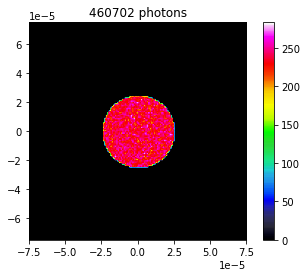

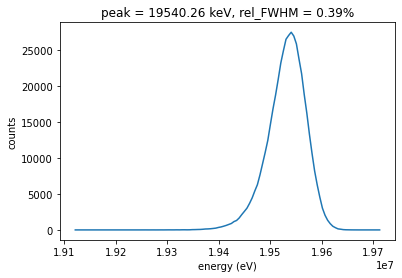

spectrum sum 460702.0 should match one in intensity plot (no attenuation)
spectrum sum 460702.0 is after window transmission and plotted above
relative flux through aperture (from *total* luminosity, BW = 1): 2.012e-03


In [164]:
# set up plots
myview = display(ListedColormap,[])
myview.apply_my_preferred_colormap()  # I like this lasercam false color display and use it everywhere
myview.set_full_view(detector)
# intensity plot
myview.viewIntensity(data,detector,window)
# get the overall spectrum of beam that makes it through aperture
fullspectrum = myview.full_aperture_spectrum(data,detector,window)
spectrum = myview.apply_attenuation(fullspectrum, detector, window)
myview.plotSpectrum(spectrum, detector)
print(f'spectrum sum {np.sum(fullspectrum)} should match one in intensity plot (no attenuation)') 
print(f'spectrum sum {np.sum(spectrum)} is after window transmission and plotted above')
# if we want to scale a luminosity formula, we can calculate the fraction of "full bandwidth" scattering
# this fraction compensates sampled BW if it is high enough not to cut-off energies that should be in the histogram
rel_flux_in_aperture = np.sum(spectrum)/np.sum(data)*(1-minP)  # minP defined earlier = detector.minP(beam,NdYAG)[0]
print(f'relative flux through aperture (from *total* luminosity, BW = 1): {rel_flux_in_aperture:0.3e}')
#savearray = np.column_stack((detector.array_E_bins(), spectrum[1:-1]))
#np.savetxt("spectrum.txt",savearray,delimiter="\t")

spectrum at (0.0, 0.001) rad in a box 0.01 mrad per side


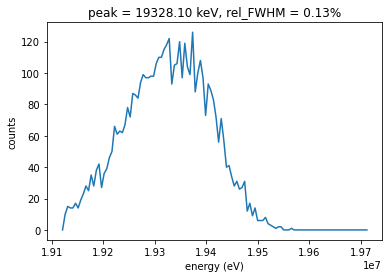

In [165]:
# we could zoom in to a particular spot to see local spectrum
spotspectrum = myview.sampled_spectrum(0.000,0.001,3,data,detector) # give coordinates xp, yp, and bin size b (2n+1 x 2n+1)
myview.plotSpectrum(spotspectrum, detector)

0.1 mrad is 50 bins
spectrum at (0.0, 0.0) rad in a box 0.10 mrad per side
total number of photons = 2390828


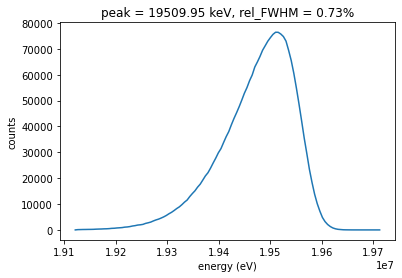

In [166]:
# quick estimate to see a central spectrum over a smaller aperture (say 0.1 mrad) **square**
b = int(1e-4/detector.dtheta/2)
print(f'0.1 mrad is {b} bins')
spotspectrum = myview.sampled_spectrum(0.000,0.000,b,data,detector) # give coordinates xp, yp, and bin size b (2n+1 x 2n+1)
print(f'total number of photons = {np.sum(spotspectrum)}')
myview.plotSpectrum(spotspectrum, detector)

window        -> aperture(toIP=10.0, dia=0.001, thick=0, angle=0, thin=0, material='Si')
overall transmission through thin window = 1.000


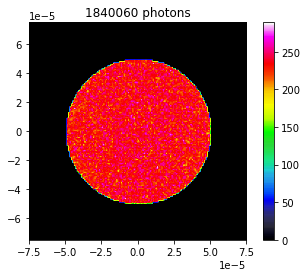

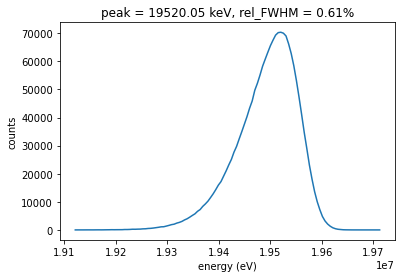

In [167]:
# another way to see central spectrum over a smaller aperture (say 4 mrad **round**) is create a new aperture!
alternate_window = aperture(10.0,1.0e-3,0,0,0)  # use simple geometry to set angle (i.e. IP at 1m)
print('window        ->', alternate_window)
# plot intensity and new 'full' spectrum
myview.viewIntensity(data,detector,alternate_window)
new_fullspectrum = myview.full_aperture_spectrum(data,detector,alternate_window)
new_spectrum = myview.apply_attenuation(new_fullspectrum, detector, window) # if you want to keep old window transmission
myview.plotSpectrum(new_fullspectrum, detector)